In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import rotate
#for standardizing data matrix
from sklearn.preprocessing import scale
#for PCA
from sklearn.decomposition import PCA as sklearnPCA
#for randomly splitting data into training and test sets
from sklearn.model_selection import train_test_split
#linear regression package
from sklearn import linear_model 
#for hyperspectral decomposition
from sklearn.decomposition import FastICA, NMF
#for calculating p value
from scipy.stats import f
hyper_list=np.load('../MATDAT18_CorrelatedAFM/hyperspectral_2d.npy')
exp_wavenumber=np.load('../MATDAT18_CorrelatedAFM/wavenumber.npy')

First perform a 2 compnent NMF and look at the components. 

In [173]:
NMF_model=NMF(n_components=2, init='random', random_state=0, max_iter=1000)
NMF_fit=NMF_model.fit_transform(hyper_list[:,1:])
NMF_comp=NMF_model.components_


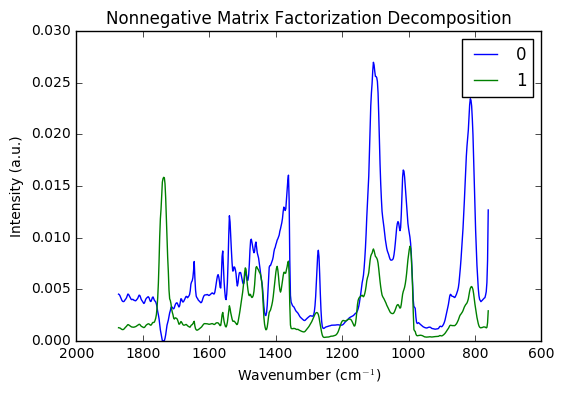

In [174]:
%matplotlib inline
for i in range(NMF_comp.shape[0]):
    plt.plot(exp_wavenumber[1:], NMF_comp[i,:], label = i) 
plt.legend()

#plt.plot(exp_wavenumber[1:], NMF_comp[0,:])
#plt.plot(exp_wavenumber[1:], NMF_comp[1,:])
plt.gca().invert_xaxis()
plt.title('Nonnegative Matrix Factorization Decomposition')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')

In [175]:
# Jessica's plotting function
def show(img, cmap = 'plasma', colorbar = True):
    """Displays image with colorbar."""
    fig = plt.imshow(img, cmap = cmap)
    imgstd = img.std()
    imgmean = img.mean()
    ll = imgmean - (2*imgstd)
    ul = imgmean + (2*imgstd)
    plt.clim(ll,ul)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if colorbar == True:
        plt.colorbar()
    return 

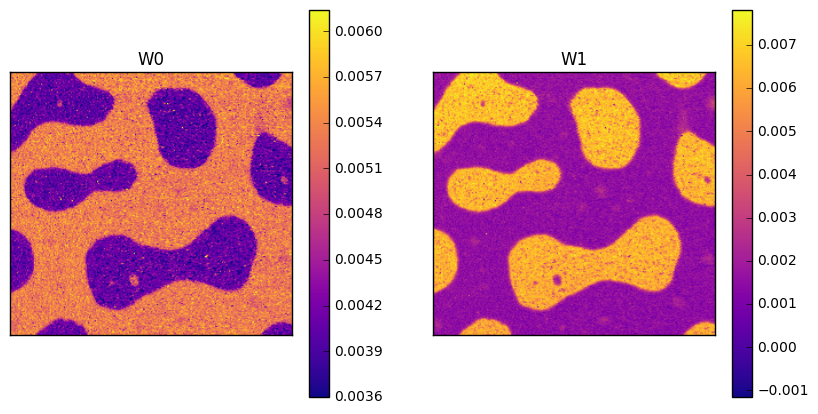

In [176]:
to_plot=NMF_fit.reshape((231,247,2))

plt.figure(figsize=(10,5))
plt.subplot(121), show(to_plot[:,:,0]), plt.title('W0')
plt.subplot(122), show(to_plot[:,:,1]), plt.title('W1')
plt.show()


# Random Forest Regressor

In [177]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score, make_scorer
mse_scorer = make_scorer('mean_squared_error')
from sklearn.preprocessing import StandardScaler

We want to predict the electrical current for a pixel using its spectra. The first step is to scale the electrical current, as it's on a pico (really really small) scale. So we use scikit's automatic function that standardizes by the standard deviation and centers on the mean. 

In [154]:
#y=np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
#y=scale(y,axis=0)

Just kidding, that didn't work great in terms of unscaling. Instead, just multiply the response out of the pic scale by multiplying y*1e-12. 

In [190]:
y=np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
scaled_y = y*1e12

In [191]:
# Use the NMF componenets as the covariates and current as the response
X = NMF_fit
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#kf.get_n_splits(X)

    
# build One model first
#X_train, X_test, y_train, y_test = train_test_split(X, scaled_y, test_size=0.2, random_state=0)
rf_regr = RandomForestRegressor()
#model = rf_regr.fit(X_train, y_train)

#make 5 folds
k_fold = KFold(n_splits=5, shuffle=True)
[rf_regr.fit(X[train], scaled_y[train]).score(X[test], scaled_y[test]) for train, test in k_fold.split(X)]


#regr_rf = RandomForestRegressor()
#regr_rf.fit(X_train, y_train)


#from sklearn import metrics
#cross_val_score(regr, X, y, cv=5, scoring=mse_scorer)

#for train_index, test_index in kf.split(X):
#    mod = regr.fit(X[, y)
#    print(mod.score())
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)


Cross-validated scores: [ 0.87590792  0.85468474  0.85602183  0.89704796  0.8110213 ]


[0.90364197257094547,
 0.90640069904190024,
 0.89937479208656979,
 0.90188894469797687,
 0.90049998472117154]

Great. So we have model scores, now we can perform a search for the best parameters using cross validation

In [198]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[10,50,100,500], 'max_features':(1,'auto')}
model = GridSearchCV(regr_rf, parameters, cv = 5,n_jobs = 4)
model.fit(X, scaled_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [10, 50, 100, 500], 'max_features': (1, 'auto')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [156]:
y = np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
pred = regr_rf.predict(X)
sd = np.std(y)
m = np.mean(y)
unscaled_y = y
unscaled_pred = pred*sd + m
error = unscaled_y - unscaled_pred

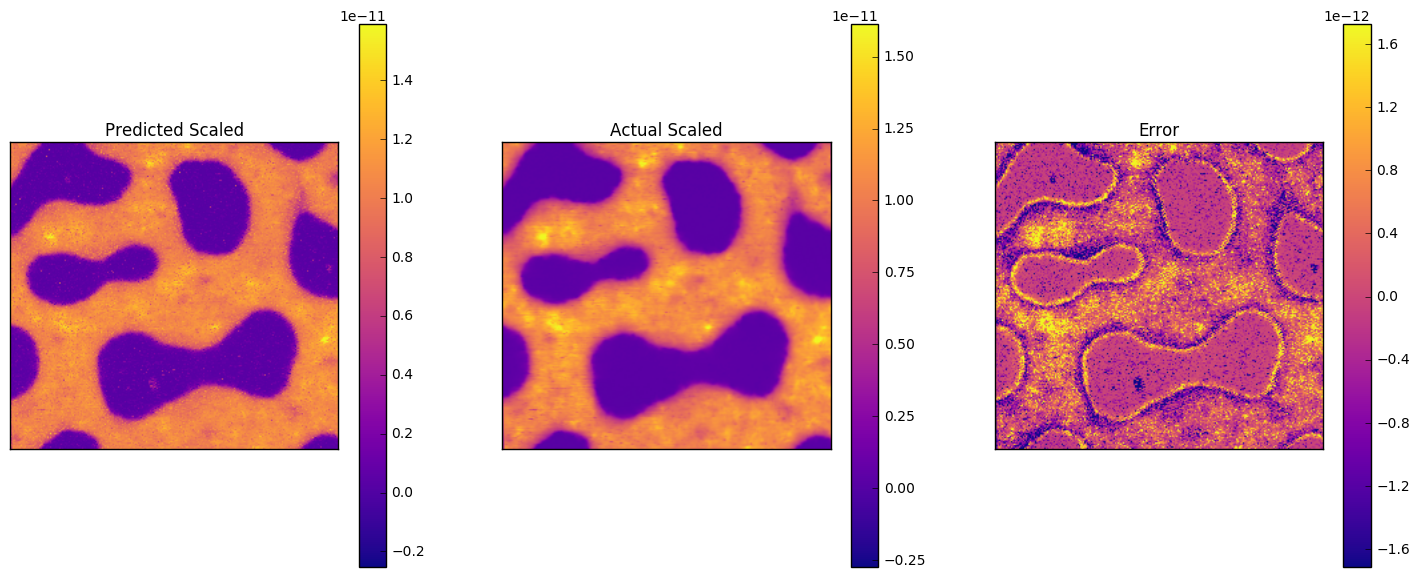

In [157]:

to_plot=unscaled_pred.reshape((231,247))
plt.figure(figsize=(18,7))
plt.subplot(131), show(to_plot), plt.title('Predicted Scaled')
plt.subplot(132), show(unscaled_y.reshape((231,247))), plt.title('Actual Scaled')
plt.subplot(133), show(error.reshape((231,247))), plt.title('Error')

plt.show()


In [134]:
#load the current and reshape to vector

#X = hyper_list[:,1:]
X = hyper_list[:,1:]
y=np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
y=scale(y,axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#make 5 folds
#kf = KFold(n_splits=5)
#kf.get_n_splits(X)
# build One model first

regr_rf = RandomForestRegressor()
regr_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [152]:
y = np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
pred = regr_rf.predict(X)
sd = np.std(y)
m = np.mean(y)
unscaled_y = y
unscaled_pred = pred*sd + m
error = unscaled_y - unscaled_pred

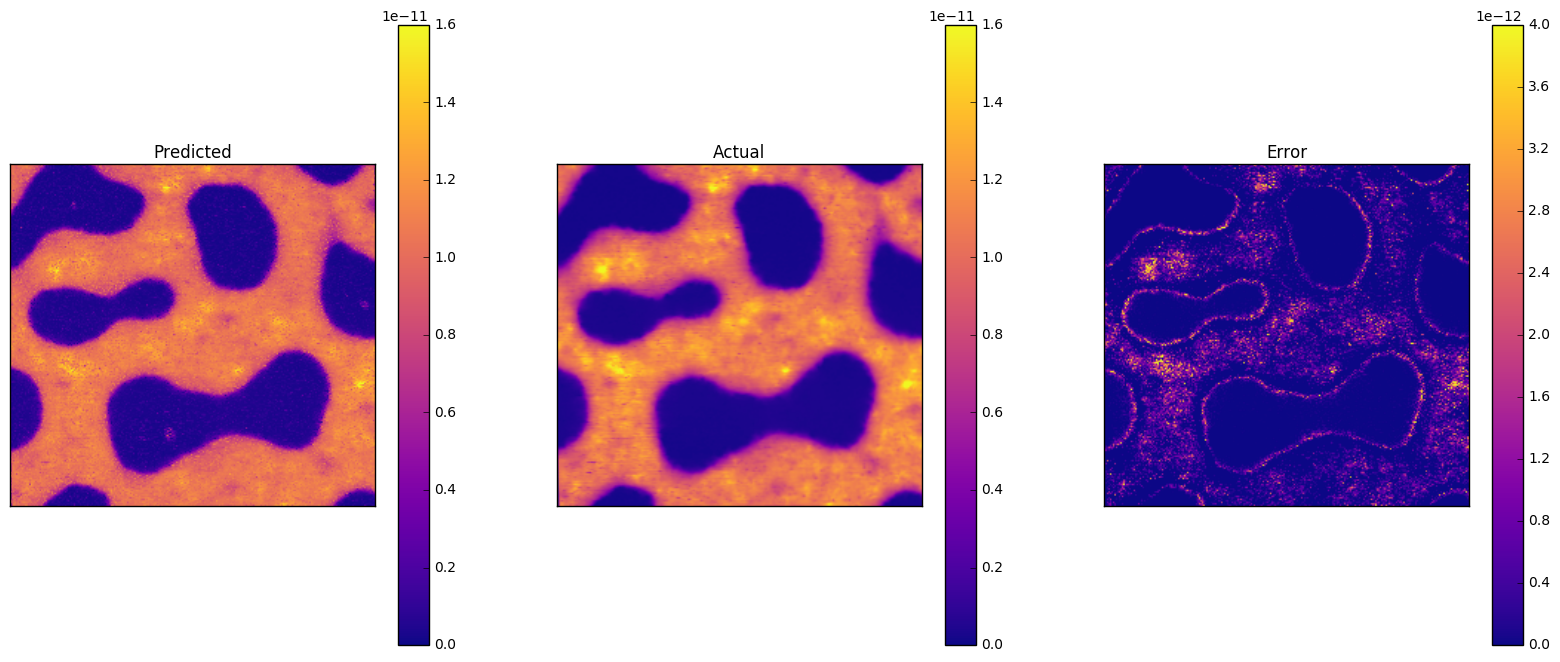

In [143]:
to_plot=unscaled_pred.reshape((231,247))
plt.figure(figsize=(20,8))
plt.subplot(131), show(to_plot), plt.title('Predicted')
plt.clim(0,16e-12)
plt.subplot(132), show(unscaled_y.reshape((231,247))), plt.title('Actual')
plt.clim(0,16e-12)
plt.subplot(133), show(error.reshape((231,247))), plt.title('Error')
plt.clim(0,4e-12)
plt.show()

# SVR

In [165]:
from sklearn.svm import SVR
from sklearn.svm.classes import NuSVR
X = hyper_list[:,1:]
y=np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
y=scale(y,axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#make 5 folds
#kf = KFold(n_splits=5)
#kf.get_n_splits(X)
# build One model first

regr_sv = NuSVR(C = 3, nu = 0.2)
regr_sv.fit(X_train, y_train) 

NuSVR(C=3, cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.2, shrinking=True, tol=0.001, verbose=False)

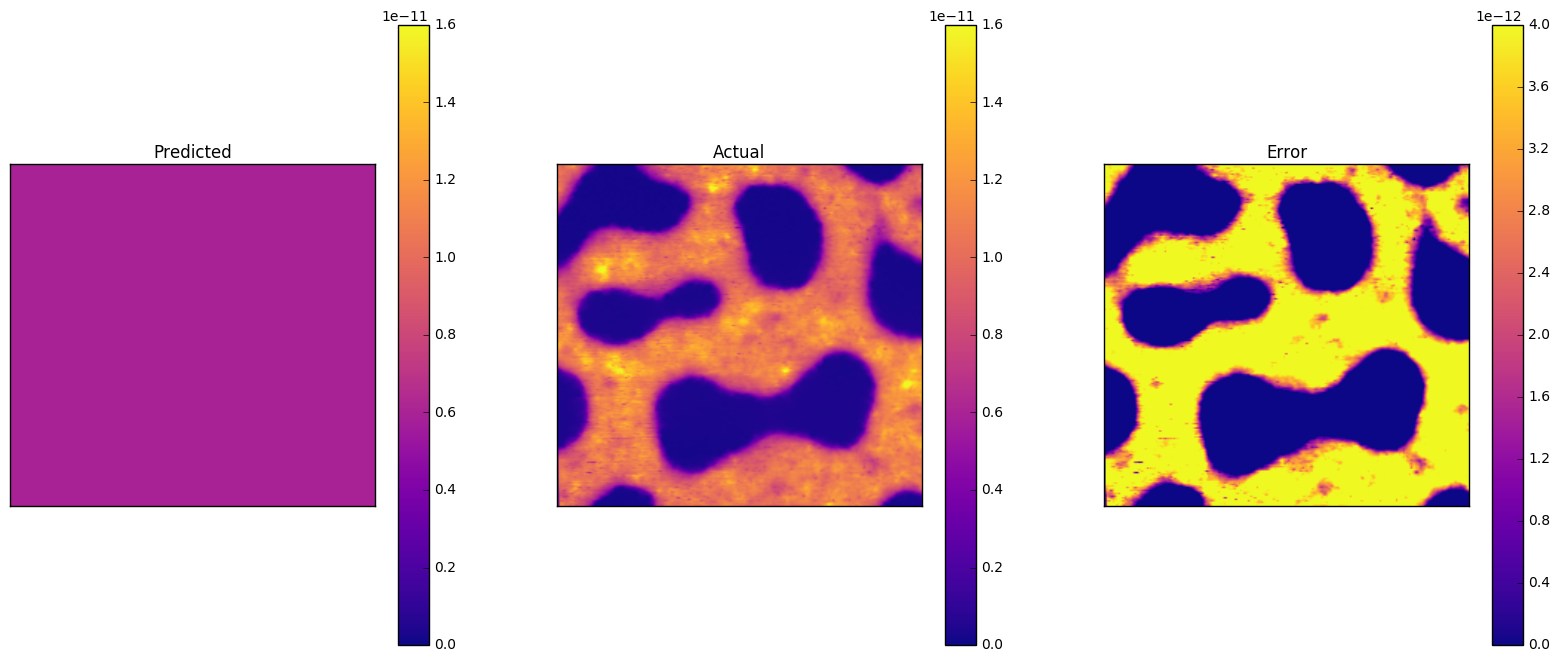

In [166]:
y = np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
pred = regr_sv.predict(X)
sd = np.std(y)
m = np.mean(y)
unscaled_y = y
unscaled_pred = pred*sd + m
error = unscaled_y - unscaled_pred

to_plot=unscaled_pred.reshape((231,247))
plt.figure(figsize=(20,8))
plt.subplot(131), show(to_plot), plt.title('Predicted')
plt.clim(0,16e-12)
plt.subplot(132), show(unscaled_y.reshape((231,247))), plt.title('Actual')
plt.clim(0,16e-12)
plt.subplot(133), show(error.reshape((231,247))), plt.title('Error')
plt.clim(0,4e-12)
plt.show()